<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/main/I'm%20madly%20genius%20guy%20that%20i%20already%20knew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Aethel_RL_Agent.py - Revised with Error Fixes and Improvements
import numpy as np
from collections import defaultdict
import random

# --- Improved Simplified Market Environment ---
# Represents a very basic market with an agent managing cash and one type of stock.
class SimpleMarketEnv:
    def __init__(self, initial_cash=1000.0, initial_stock_price=100.0, stock_id='AAPL'):
        self.initial_cash = initial_cash
        self.initial_stock_price = initial_stock_price
        self.stock_id = stock_id

        self.cash = initial_cash
        self.stocks_held = 0
        self.current_stock_price = initial_stock_price
        self.market_trend = 'neutral' # 'bull', 'bear', 'neutral'

        self.time_step = 0
        self.max_time_steps = 100 # Define max steps per episode

    def _get_observation(self):
        # State now includes: [cash_normalized, stocks_held_normalized, current_stock_price_normalized, market_trend_encoded]
        # Normalizing values helps the agent learn better.
        max_portfolio_value = self.initial_cash + (self.initial_cash / self.initial_stock_price) * self.initial_stock_price * 2 # Rough estimate
        max_stocks = self.initial_cash / self.initial_stock_price * 2

        # Encoding market trend: 0=bull, 1=bear, 2=neutral
        trend_map = {'bull': 0, 'bear': 1, 'neutral': 2}

        return (
            self.cash / max_portfolio_value,
            self.stocks_held / max_stocks,
            self.current_stock_price / (self.initial_stock_price * 2), # Assuming price won't double beyond this for normalization
            trend_map[self.market_trend]
        )

    def _update_market_trend(self):
        # Randomly change market trend
        r = random.random()
        if r < 0.3:
            self.market_trend = 'bull'
        elif r < 0.6:
            self.market_trend = 'bear'
        else:
            self.market_trend = 'neutral'

    def _simulate_stock_price_change(self):
        change_percentage = 0.0 # Default no change
        if self.market_trend == 'bull':
            change_percentage = random.uniform(0.005, 0.015) # +0.5% to +1.5%
        elif self.market_trend == 'bear':
            change_percentage = random.uniform(-0.015, -0.005) # -1.5% to -0.5%
        else: # neutral
            change_percentage = random.uniform(-0.002, 0.002) # -0.2% to +0.2%

        self.current_stock_price *= (1 + change_percentage)
        self.current_stock_price = max(0.01, self.current_stock_price) # Price can't go to zero

    def step(self, action):
        # Action space: 0 (Hold), 1 (Buy 10% of cash into stocks), 2 (Sell 10% of stocks to cash)

        prev_portfolio_value = self.cash + (self.stocks_held * self.current_stock_price)

        # Apply action
        if action == 1: # Buy stocks
            buy_amount = self.cash * 0.1 # Try to use 10% of cash
            if buy_amount >= self.current_stock_price: # Ensure we can buy at least one share
                shares_to_buy = int(buy_amount / self.current_stock_price)
                cost = shares_to_buy * self.current_stock_price
                self.cash -= cost
                self.stocks_held += shares_to_buy
        elif action == 2: # Sell stocks
            if self.stocks_held > 0:
                shares_to_sell = int(self.stocks_held * 0.1) # Try to sell 10% of holdings
                if shares_to_sell == 0 and self.stocks_held > 0: # Ensure at least one share is sold if possible
                    shares_to_sell = 1

                if shares_to_sell > 0:
                    revenue = shares_to_sell * self.current_stock_price
                    self.cash += revenue
                    self.stocks_held -= shares_to_sell

        # Simulate market movement *after* action (or simultaneously, depending on model)
        self._simulate_stock_price_change()
        self._update_market_trend() # Market trend can change at each step

        self.time_step += 1
        done = self.time_step >= self.max_time_steps

        current_portfolio_value = self.cash + (self.stocks_held * self.current_stock_price)

        # Reward function: Maximize portfolio value
        # Normalize reward to prevent very large values early on
        reward = (current_portfolio_value - prev_portfolio_value) / self.initial_cash # Reward is percentage gain

        # Penalty for holding too much cash (not investing) or too many stocks in bear market
        # (More complex rewards can be added here based on risk tolerance, etc.)

        # Convert continuous state to a discrete hashable format for Q-table
        discrete_state = self._discretize_state(self._get_observation())

        return discrete_state, reward, done, {'portfolio_value': current_portfolio_value}

    def reset(self):
        self.cash = self.initial_cash
        self.stocks_held = 0
        self.current_stock_price = self.initial_stock_price
        self.market_trend = 'neutral' # Reset to neutral
        self.time_step = 0
        return self._discretize_state(self._get_observation())

    def _discretize_state(self, observation):
        # Convert continuous observation into a discrete, hashable state for the Q-table
        # This is crucial for Q-learning with continuous inputs.
        # This example uses simple binning. For more complex states, one might use clustering or neural network embeddings.
        cash_bin = int(observation[0] * 10) # 0-9
        stocks_bin = int(observation[1] * 10) # 0-9
        price_bin = int(observation[2] * 10) # 0-9
        trend_encoded = int(observation[3]) # 0, 1, 2

        # Combine into a tuple for hashability
        return (cash_bin, stocks_bin, price_bin, trend_encoded)

# --- Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, num_actions, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.q_table = defaultdict(lambda: np.zeros(num_actions))
        self.num_actions = num_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randrange(self.num_actions) # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def learn(self, state, action, reward, next_state, done):
        old_value = self.q_table[state][action]

        if done:
            next_max = 0 # No future reward if episode is over
        else:
            next_max = np.max(self.q_table[next_state])

        new_value = old_value + self.lr * (reward + self.gamma * next_max - old_value)
        self.q_table[state][action] = new_value

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# --- Simulation ---
if __name__ == '__main__':
    env = SimpleMarketEnv(initial_cash=1000, initial_stock_price=100)
    agent = QLearningAgent(num_actions=3) # 0: Hold, 1: Buy, 2: Sell

    episodes = 5000 # Increased episodes for better learning

    print("Starting RL Agent Training (Hyper-Personalized Portfolio Simulation - Fixed Errors)...")
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, info = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        if episode % 500 == 0:
            print(f"Episode {episode}: Total Reward = {total_reward:.4f}, Final Portfolio Value = {info['portfolio_value']:.2f}, Epsilon = {agent.epsilon:.4f}")

    print("\nTraining complete.")
    print("Aethel's RL agent learned a basic portfolio strategy to maximize value.")

    # Example Q-table entries (will be sparse and depends on observed states)
    print("\nExample Q-table entries (some learned strategies):")
    for state_tuple, q_values in list(agent.q_table.items())[:5]: # Print first 5 learned states
        print(f"  State {state_tuple} (Cash, Stocks, Price, Trend) -> Actions Q-Values: {q_values}")

    # Test the learned policy (greedy actions)
    print("\n--- Testing Learned Policy ---")
    env.reset()
    agent.epsilon = 0 # Turn off exploration for testing
    state = env.reset()
    done = False
    test_portfolio_value = env.cash + (env.stocks_held * env.current_stock_price)

    for _ in range(env.max_time_steps):
        action = agent.choose_action(state) # Agent takes learned action

        action_name = {0: 'HOLD', 1: 'BUY', 2: 'SELL'}[action]
        # print(f"Time: {env.time_step}, State: {state}, Action: {action_name}, Price: {env.current_stock_price:.2f}, Cash: {env.cash:.2f}, Stocks: {env.stocks_held}")

        next_state, reward, done, info = env.step(action)
        state = next_state
        test_portfolio_value = info['portfolio_value']
        if done:
            break

    print(f"Test Run: Final Portfolio Value = {test_portfolio_value:.2f}")
    print(f"Initial Portfolio Value: {env.initial_cash:.2f}")

    print("\nIn a real-world Aethel, the environment would be far more complex,")
    print("using real market data, diverse assets, and a deep neural network for the Q-function (Deep Q-Network - DQN).")
    print("The state would include many more features like indicators, news sentiment, and investor's risk tolerance.")

Starting RL Agent Training (Hyper-Personalized Portfolio Simulation - Fixed Errors)...
Episode 0: Total Reward = 0.0029, Final Portfolio Value = 1002.93, Epsilon = 0.6058
Episode 500: Total Reward = 0.0168, Final Portfolio Value = 1016.78, Epsilon = 0.0100
Episode 1000: Total Reward = 0.0157, Final Portfolio Value = 1015.73, Epsilon = 0.0100
Episode 1500: Total Reward = 0.0259, Final Portfolio Value = 1025.88, Epsilon = 0.0100
Episode 2000: Total Reward = 0.0221, Final Portfolio Value = 1022.12, Epsilon = 0.0100
Episode 2500: Total Reward = 0.0211, Final Portfolio Value = 1021.06, Epsilon = 0.0100
Episode 3000: Total Reward = 0.0252, Final Portfolio Value = 1025.20, Epsilon = 0.0100
Episode 3500: Total Reward = 0.0260, Final Portfolio Value = 1025.96, Epsilon = 0.0100
Episode 4000: Total Reward = 0.0237, Final Portfolio Value = 1023.71, Epsilon = 0.0100
Episode 4500: Total Reward = 0.0049, Final Portfolio Value = 1004.91, Epsilon = 0.0100

Training complete.
Aethel's RL agent learned a

In [3]:
# Aethel_Predictive_Analytics.py
import pandas as pd
from sklearn.ensemble import IsolationForest
from transformers import pipeline # For sentiment analysis
import random
import datetime

# --- Mock Data Generation ---
def generate_mock_data(num_samples=100):
    data = []
    for i in range(num_samples):
        timestamp = datetime.datetime.now() - datetime.timedelta(minutes=num_samples - i)
        price = random.uniform(100, 105) # Base price
        volume = random.randint(1000, 5000)
        sentiment = random.uniform(-1, 1) # Mock sentiment
        headline = "Market stable." # Mock headline

        # Introduce a "black swan" anomaly
        if i == num_samples // 2: # Around midpoint
            price *= 1.15 # 15% spike
            volume *= 5 # 5x volume spike
            sentiment = -0.95 # Very negative sentiment
            headline = "Company X under investigation for fraud!"
        elif i == num_samples // 2 + 1:
            price *= 0.90 # Immediate drop after spike
            sentiment = -0.8
            headline = "Regulators open probe into Company X."

        data.append({
            'timestamp': timestamp,
            'price': price,
            'volume': volume,
            'news_sentiment': sentiment,
            'news_headline': headline
        })
    return pd.DataFrame(data)

# --- Multi-Modal Anomaly Detection ---
class MultiModalAnomalyDetector:
    def __init__(self):
        # Isolation Forest for numerical anomalies
        self.price_volume_model = IsolationForest(contamination=0.05, random_state=42)
        # Hugging Face pipeline for sentiment (pre-trained, could be fine-tuned)
        self.sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

    def analyze_sentiment(self, text):
        # Returns score (e.g., {'label': 'POSITIVE', 'score': 0.999})
        result = self.sentiment_analyzer(text)[0]
        return result['score'] if result['label'] == 'POSITIVE' else -result['score']

    def detect_anomalies(self, df):
        # 1. Numerical Anomaly Detection (Price & Volume)
        df['price_volume_anomaly'] = self.price_volume_model.fit_predict(df[['price', 'volume']])
        df['is_price_volume_anomaly'] = (df['price_volume_anomaly'] == -1)

        # 2. Sentiment Anomaly Detection (using mock sentiment for demonstration)
        # In a real scenario, you'd apply self.analyze_sentiment to df['news_headline']
        # For this mock, we use the pre-generated sentiment.
        # You could also use a separate anomaly detector for sentiment distribution.

        # 3. Multi-Modal Fusion (Simplified: check for co-occurrence of anomalies)
        # A real fusion would use more advanced techniques like deep learning or probabilistic graphical models
        df['multi_modal_anomaly'] = False
        for i, row in df.iterrows():
            if row['is_price_volume_anomaly']:
                # If price/volume is anomalous, check if sentiment is also extreme/negative
                if row['news_sentiment'] < -0.7: # Threshold for 'very negative' sentiment
                    df.loc[i, 'multi_modal_anomaly'] = True
        return df

if __name__ == '__main__':
    print("Generating mock multi-modal financial data...")
    mock_df = generate_mock_data(num_samples=200)

    detector = MultiModalAnomalyDetector()

    print("Detecting multi-modal anomalies (e.g., price spike + negative news sentiment)...")
    result_df = detector.detect_anomalies(mock_df.copy()) # Use a copy to avoid modifying original

    print("\nDetected Anomalies (Price/Volume + Extreme Negative Sentiment):")
    anomalies = result_df[result_df['multi_modal_anomaly']]
    if not anomalies.empty:
        for _, row in anomalies.iterrows():
            print(f"Timestamp: {row['timestamp']}, Price: {row['price']:.2f}, Volume: {row['volume']},"
                  f" Sentiment: {row['news_sentiment']:.2f}, Headline: '{row['news_headline']}'")
    else:
        print("No multi-modal anomalies detected in this simulation.")

    # Visualizing the mock data (conceptually)
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(12, 6))
    # plt.plot(result_df['timestamp'], result_df['price'], label='Price')
    # plt.scatter(anomalies['timestamp'], anomalies['price'], color='red', s=100, label='Multi-Modal Anomaly')
    # plt.title("Stock Price with Multi-Modal Anomalies")
    # plt.xlabel("Time")
    # plt.ylabel("Price")
    # plt.legend()
    # plt.show()

Generating mock multi-modal financial data...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Detecting multi-modal anomalies (e.g., price spike + negative news sentiment)...

Detected Anomalies (Price/Volume + Extreme Negative Sentiment):
Timestamp: 2025-11-13 04:41:45.438961, Price: 101.32, Volume: 4925, Sentiment: -0.84, Headline: 'Market stable.'
Timestamp: 2025-11-13 04:48:45.439017, Price: 104.28, Volume: 4981, Sentiment: -0.72, Headline: 'Market stable.'
Timestamp: 2025-11-13 06:16:45.439499, Price: 118.88, Volume: 15180, Sentiment: -0.95, Headline: 'Company X under investigation for fraud!'
Timestamp: 2025-11-13 06:17:45.439505, Price: 91.79, Volume: 4585, Sentiment: -0.80, Headline: 'Regulators open probe into Company X.'


In [4]:
# Aethel_Autonomous_Trading.py
import numpy as np
import random
# Mock Keras/TensorFlow for a simple neural network
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    print("Using TensorFlow for DRL agent.")
except ImportError:
    tf = None
    print("TensorFlow not found. DRL agent will use a dummy model.")

# --- Simplified Execution Environment (dummy) ---
class ExecutionEnv:
    def __init__(self, total_shares_to_sell=100, initial_market_price=100.0):
        self.total_shares_to_sell = total_shares_to_sell
        self.shares_remaining = total_shares_to_sell
        self.current_market_price = initial_market_price
        self.time_step = 0
        self.max_time_steps = 10 # To complete execution
        self.executed_price_sum = 0
        self.executed_shares_sum = 0

    def _get_observation(self):
        # State: [shares_remaining, current_market_price, time_ratio]
        return np.array([
            self.shares_remaining / self.total_shares_to_sell, # Normalized
            self.current_market_price / 100.0, # Normalized (assuming base 100)
            self.time_step / self.max_time_steps
        ])

    def step(self, action):
        # Action: amount of shares to sell in this step (0 to 10% of remaining)
        # Simplified: Action 0 = 0% of remaining, Action 1 = 5%, Action 2 = 10%
        sell_percentage = [0, 0.05, 0.1][action]
        shares_to_execute = min(int(self.shares_remaining * sell_percentage), self.shares_remaining)

        # Simulate market price impact (very simple slippage)
        slippage = (shares_to_execute / self.total_shares_to_sell) * 0.01 # Larger orders, more slippage
        executed_price = self.current_market_price * (1 - slippage)

        # Update state
        self.shares_remaining -= shares_to_execute
        self.executed_shares_sum += shares_to_execute
        self.executed_price_sum += executed_price * shares_to_execute
        self.time_step += 1

        # Simulate market price fluctuation for next step (random walk)
        self.current_market_price += random.uniform(-0.5, 0.5)

        done = self.shares_remaining <= 0 or self.time_step >= self.max_time_steps

        # Reward: penalize remaining shares and incentivize good execution price
        reward = 0
        if shares_to_execute > 0:
            reward = executed_price # Reward for executing

        if self.shares_remaining <= 0:
            reward += 100 # Large reward for completing the order

        # Penalize for not completing order or for taking too long
        if done and self.shares_remaining > 0:
            reward -= self.shares_remaining * 2 # Penalty for unexecuted shares

        return self._get_observation(), reward, done, {}

    def reset(self):
        self.shares_remaining = self.total_shares_to_sell
        self.current_market_price = 100.0
        self.time_step = 0
        self.executed_price_sum = 0
        self.executed_shares_sum = 0
        return self._get_observation()

# --- DRL Agent (DQN-like structure) ---
class DRLTradingAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self._build_model(learning_rate)
        # In a real DQN, you'd also have a target model and replay memory

    def _build_model(self, learning_rate):
        if tf:
            model = Sequential()
            model.add(Dense(24, input_dim=self.state_size, activation='relu'))
            model.add(Dense(24, activation='relu'))
            model.add(Dense(self.action_size, activation='linear')) # Output Q-values for each action
            model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
            return model
        else:
            # Dummy model if TensorFlow is not available
            class DummyModel:
                def predict(self, state):
                    return np.random.rand(1, self.action_size)
                def fit(self, state, target_q_values, epochs, verbose):
                    pass
            return DummyModel()

    def choose_action(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size) # Explore
        q_values = self.model.predict(state.reshape(1, -1))[0]
        return np.argmax(q_values) # Exploit

    def learn(self, state, action, reward, next_state, done):
        if tf:
            target = reward
            if not done:
                # Bellman equation for Q-learning
                target = (reward + self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1))[0]))

            target_f = self.model.predict(state.reshape(1, -1))
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# --- Simulation ---
if __name__ == '__main__':
    env = ExecutionEnv()
    state_size = env._get_observation().shape[0]
    action_size = 3 # 0%, 5%, 10% shares to sell
    agent = DRLTradingAgent(state_size, action_size)

    episodes = 100
    print("Starting DRL Agent Training (Autonomous Trading Simulation)...")
    for e in range(episodes):
        state = env.reset()
        done = False
        total_executed_shares = 0
        total_reward = 0
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_executed_shares = env.total_shares_to_sell - env.shares_remaining
            total_reward += reward

        avg_executed_price = env.executed_price_sum / env.executed_shares_sum if env.executed_shares_sum > 0 else 0

        print(f"Episode {e}/{episodes}: Shares Executed: {total_executed_shares}/{env.total_shares_to_sell},"
              f" Avg Price: {avg_executed_price:.2f}, Remaining: {env.shares_remaining},"
              f" Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

    print("\nTraining complete.")
    print("Aethel's DRL agent learned a basic order execution strategy.")
    print("In a real system, this would involve high-frequency data, real-time market impact models, and multi-objective optimization (e.g., speed, price, market impact).")

Using TensorFlow for DRL agent.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting DRL Agent Training (Autonomous Trading Simulation)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Episode 0/100: Shares Executed: 45/100, Avg Price: 99.06, Remaining: 55, Total Reward: 682.11, Epsilon: 0.95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [5]:
# Aethel_Risk_Management.py
import networkx as nx
import random

class SystemicRiskMonitor:
    def __init__(self):
        self.financial_graph = nx.DiGraph() # Directed graph for dependencies (e.g., A owes B)

    def add_entity(self, entity_id, entity_type, assets=0, liabilities=0):
        self.financial_graph.add_node(entity_id, type=entity_type, assets=assets, liabilities=liabilities, healthy=True)

    def add_dependency(self, debtor_id, creditor_id, amount):
        # A owes B an amount
        if not self.financial_graph.has_node(debtor_id) or not self.financial_graph.has_node(creditor_id):
            raise ValueError("Debtor or Creditor entity not found.")
        self.financial_graph.add_edge(debtor_id, creditor_id, weight=amount)

    def _propagate_failure(self, failed_entity_id, initial_shock=0.1):
        # Simplified: if an entity fails, its creditors lose a percentage of what's owed.
        # This can cause cascading failures.
        impacted_entities = {failed_entity_id}
        newly_failed = {failed_entity_id}

        self.financial_graph.nodes[failed_entity_id]['healthy'] = False
        self.financial_graph.nodes[failed_entity_id]['assets'] -= self.financial_graph.nodes[failed_entity_id]['liabilities'] # Simulate insolvency

        iteration = 0
        while newly_failed and iteration < 10: # Limit iterations to prevent infinite loops
            current_failures = newly_failed
            newly_failed = set()
            iteration += 1

            for failed_node in current_failures:
                # Find all entities that are creditors to the failed_node
                for u, v, data in self.financial_graph.edges(data=True):
                    if u == failed_node: # failed_node is a debtor to v
                        creditor = v
                        amount_owed = data['weight']

                        if self.financial_graph.nodes[creditor]['healthy']:
                            # Creditor loses part of the asset owed by failed_node
                            loss = amount_owed * initial_shock
                            self.financial_graph.nodes[creditor]['assets'] -= loss

                            if self.financial_graph.nodes[creditor]['assets'] < self.financial_graph.nodes[creditor]['liabilities']:
                                # Creditor becomes insolvent
                                self.financial_graph.nodes[creditor]['healthy'] = False
                                newly_failed.add(creditor)
                                impacted_entities.add(creditor)
                                print(f"  --> Cascading failure: Entity {creditor} ({self.financial_graph.nodes[creditor]['type']}) failed due to {failed_node} loss.")
        return impacted_entities

    def identify_systemic_risk(self):
        # Identify central nodes (high degree, high betweenness centrality)
        # Simplified: just use degree for now
        degrees = dict(self.financial_graph.degree())
        sorted_entities = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

        print("Entity interconnectedness (degree):", sorted_entities)

        # Simulate a random entity failure and see cascade
        if not self.financial_graph.nodes:
            print("No entities in the graph to simulate failure.")
            return

        for _ in range(3): # Run a few simulations
            # Reset health for simulation
            for node in self.financial_graph.nodes:
                self.financial_graph.nodes[node]['healthy'] = True
                # Reset assets to initial state for a fresh simulation
                self.financial_graph.nodes[node]['assets'] = random.uniform(500, 1500)
                self.financial_graph.nodes[node]['liabilities'] = random.uniform(200, 800)

            random_entity = random.choice(list(self.financial_graph.nodes))
            print(f"\nSimulating failure of a critical entity: {random_entity} ({self.financial_graph.nodes[random_entity]['type']})...")
            impacted = self._propagate_failure(random_entity, initial_shock=0.2)
            print(f"Total entities impacted: {len(impacted)}")
            if len(impacted) > 1:
                print(f"Systemic risk detected: Failure of {random_entity} caused cascading failures.")
            else:
                print(f"Failure of {random_entity} was contained.")

if __name__ == '__main__':
    monitor = SystemicRiskMonitor()

    # Create mock financial entities
    monitor.add_entity('BankA', 'Bank', assets=1000, liabilities=800)
    monitor.add_entity('HedgeFundB', 'Hedge Fund', assets=700, liabilities=600)
    monitor.add_entity('InsurerC', 'Insurance Co', assets=1200, liabilities=900)
    monitor.add_entity('CorpD', 'Corporation', assets=500, liabilities=400)
    monitor.add_entity('PensionF', 'Pension Fund', assets=900, liabilities=700)

    # Add dependencies (who owes whom)
    monitor.add_dependency('BankA', 'InsurerC', 100)
    monitor.add_dependency('HedgeFundB', 'BankA', 150)
    monitor.add_dependency('CorpD', 'HedgeFundB', 50)
    monitor.add_dependency('BankA', 'PensionF', 200)
    monitor.add_dependency('PensionF', 'CorpD', 80)
    monitor.add_dependency('InsurerC', 'BankA', 300) # Circular dependency

    print("Aethel's Next-Gen Risk Management (Systemic Risk Simulation):")
    monitor.identify_systemic_risk()

    print("\nThis is a highly simplified graph model. A real system would use:")
    print(" - Billions of nodes and edges.")
    print(" - Dynamic liabilities/assets based on real-time market data.")
    print(" - Advanced graph algorithms (PageRank, Betweenness Centrality) to identify critical nodes.")
    print(" - LLMs to analyze geopolitical/event data for initial shock estimation.")
    print(" - Quantum computing for faster graph analysis on massive datasets.")

Aethel's Next-Gen Risk Management (Systemic Risk Simulation):
Entity interconnectedness (degree): [('BankA', 4), ('HedgeFundB', 2), ('InsurerC', 2), ('CorpD', 2), ('PensionF', 2)]

Simulating failure of a critical entity: InsurerC (Insurance Co)...
Total entities impacted: 1
Failure of InsurerC was contained.

Simulating failure of a critical entity: HedgeFundB (Hedge Fund)...
Total entities impacted: 1
Failure of HedgeFundB was contained.

Simulating failure of a critical entity: PensionF (Pension Fund)...
Total entities impacted: 1
Failure of PensionF was contained.

This is a highly simplified graph model. A real system would use:
 - Billions of nodes and edges.
 - Dynamic liabilities/assets based on real-time market data.
 - Advanced graph algorithms (PageRank, Betweenness Centrality) to identify critical nodes.
 - LLMs to analyze geopolitical/event data for initial shock estimation.
 - Quantum computing for faster graph analysis on massive datasets.


In [12]:
# Aethel_Generative_Insights.py - Perfected Code
# This example uses Google's Generative AI API.
# You need to install google-generativeai: pip install google-generativeai python-dotenv Flask
# And set your GOOGLE_API_KEY in a .env file (e.g., GOOGLE_API_KEY=your_actual_key_here).

import os
import google.generativeai as genai
from flask import Flask, request, jsonify
from dotenv import load_dotenv

# Load environment variables from .env file at the beginning
load_dotenv()

app = Flask(__name__)

# --- Configure Google Generative AI ---
# Retrieve the API key from environment variables
# Ensure the .env file has GOOGLE_API_KEY=YOUR_API_KEY
GOOGLE_API_KEY_ENV_VAR = "GOOGLE_API_KEY"
GOOGLE_API_KEY = os.getenv(GOOGLE_API_KEY_ENV_VAR)

if not GOOGLE_API_KEY:
    # Use a more specific error message to guide the user
    raise ValueError(f"'{GOOGLE_API_KEY_ENV_VAR}' not found in environment variables or .env file. Please set it.")

# Configure the Generative AI client with the retrieved API key
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize the Generative Model
try:
    model = genai.GenerativeModel('gemini-pro')
    # Optional: Test a quick ping to ensure the API key is valid
    # model.generate_content("hello", safety_settings=[{"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"}])
    print("Google Generative Model 'gemini-pro' initialized successfully.")
except Exception as e:
    raise RuntimeError(f"Failed to initialize Google Generative Model. Check API key and network: {e}")


# --- Simulated Real-time Data / Knowledge Base (RAG context) ---
# In a real Aethel, this would query the Unified Data Lake
# or real-time market data APIs. This is a crucial "Retrieval" part of RAG.
SIMULATED_DATA = {
    "AAPL": {
        "price": 175.25,
        "change": "+1.5%",
        "sector": "Technology",
        "pe_ratio": 28.5,
        "news_summary": "Apple announces record Q3 earnings, driven by strong iPhone sales and growth in services."
    },
    "GOOGL": {
        "price": 140.10,
        "change": "-0.8%",
        "sector": "Technology",
        "pe_ratio": 25.1,
        "news_summary": "Alphabet faces antitrust scrutiny in Europe, shares dip slightly."
    },
    "MSFT": {
        "price": 350.00,
        "change": "+0.3%",
        "sector": "Technology",
        "pe_ratio": 32.0,
        "news_summary": "Microsoft expands cloud computing services, new AI partnerships."
    },
    "SPY_ETF": {
        "price": 450.70,
        "change": "+0.2%",
        "sector": "Index ETF",
        "news_summary": "S&P 500 shows modest gains as inflation concerns ease."
    }
}

def get_realtime_context(query):
    """
    Retrieves relevant simulated financial data based on keywords in the query.
    This acts as the "Retrieval" part of Retrieval-Augmented Generation (RAG).
    """
    context = []
    query_lower = query.lower()

    # Keywords for general financial queries
    general_keywords = ['stock', 'price', 'news', 'etf', 'market', 'economy', 'financial']

    for symbol, data in SIMULATED_DATA.items():
        # Check if the symbol is directly mentioned or if general financial keywords are present
        if symbol.lower() in query_lower or any(k in query_lower for k in general_keywords):
            context.append(f"Current Data for {symbol}:\n"
                           f"  Price: {data['price']}\n"
                           f"  Change: {data['change']}\n"
                           f"  Sector: {data['sector']}\n"
                           f"  PE Ratio: {data['pe_ratio']}\n"
                           f"  News Summary: '{data['news_summary']}'\n")

    if not context:
        return "No specific real-time data found relevant to this query in the simulated database."
    return "Relevant Real-time Data Context:\n" + "\n".join(context)

# --- Flask API Endpoint ---
@app.route('/ask_aethel', methods=['POST'])
def ask_aethel():
    """
    API endpoint for Aethel to provide generative financial insights.
    Expects a JSON payload with a 'query' field.
    """
    data = request.get_json()
    if not data or 'query' not in data:
        return jsonify({"error": "Invalid request. Please provide a JSON body with a 'query' field."}), 400

    user_query = data['query']

    # 1. Retrieve relevant "real-time" data (RAG - Retrieval Augmented Generation)
    context_data = get_realtime_context(user_query)

    # 2. Construct the prompt for the LLM, including safety instructions
    prompt = (
        f"You are Aethel, an advanced financial intelligence AI. Your goal is to provide concise, "
        f"insightful, and actionable financial responses based on the provided context and your vast knowledge. "
        f"Strictly adhere to the following rules:\n"
        f"- **Do NOT offer financial advice or recommendations to buy/sell.** State that you provide information, not advice.\n"
        f"- If the user asks for a prediction, state that you can analyze trends and provide data-driven scenarios, but **cannot make guaranteed predictions** about future market movements.\n"
        f"- If data related to a specific entity or metric is unavailable in the provided context, clearly state that.\n"
        f"- Focus on factual analysis and implications based on the data and general financial principles.\n"
        f"- Keep responses professional and clear.\n\n"
        f"Here is the relevant real-time financial data:\n"
        f"{context_data}\n\n"
        f"User's Query: {user_query}\n\n"
        f"Aethel's Insight:"
    )

    try:
        # 3. Generate response using the LLM
        # Adding safety_settings to potentially relax overly strict default filters,
        # but use with caution and adjust based on your specific application's safety needs.
        # Blocking DANGEROUS_CONTENT to NONE means "do not block this category"
        response = model.generate_content(
            prompt,
            safety_settings=[
                {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"},
                {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE"},
                {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE"},
                {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE"},
            ]
        )
        insight = response.text
        return jsonify({"insight": insight})
    except Exception as e:
        # Log the full exception for debugging in a real application
        print(f"Error generating content from LLM: {e}")
        return jsonify({"error": f"Failed to generate insight from AI: {str(e)}. "
                                 f"This might be due to API issues, rate limits, or content policy violations."}), 500

if __name__ == '__main__':
    print("--------------------------------------------------")
    print("Aethel's Generative Financial Insights API is starting...")
    print("Access this service by sending POST requests to:")
    print("  http://127.0.0.1:5000/ask_aethel")
    print("\nExample JSON POST body:")
    print("  {'query': 'Tell me about Apple stock and its recent news.'}")
    print("  {'query': 'What is the current sentiment around Alphabet and its stock price?'}")
    print("  {'query': 'What are the PE ratios for MSFT and GOOGL?'}")
    print("  {'query': 'Should I buy Tesla stock?' (Observe AI's refusal to give advice)}")
    print("--------------------------------------------------")
    app.run(debug=True, port=5000)

ValueError: 'GOOGLE_API_KEY' not found in environment variables or .env file. Please set it.

In [10]:
# Aethel_Quantum_Integration.py
import numpy as np
from scipy.optimize import minimize

# --- Mock Financial Data ---
# Number of assets
NUM_ASSETS = 5

# Mock expected returns for each asset
# In a real system, these would come from predictive analytics
expected_returns = np.array([0.10, 0.15, 0.08, 0.12, 0.07])

# Mock covariance matrix for assets (risk)
# Needs to be symmetric and positive semi-definite
cov_matrix = np.array([
    [0.02, 0.01, 0.005, 0.01, 0.008],
    [0.01, 0.03, 0.01, 0.015, 0.012],
    [0.005, 0.01, 0.015, 0.007, 0.006],
    [0.01, 0.015, 0.007, 0.025, 0.01],
    [0.008, 0.012, 0.006, 0.01, 0.022]
])

# --- Objective Function (Minimize Risk for a Target Return) ---
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

# Objective function for optimization: we want to minimize risk
# (This is typically done by minimizing a negative utility function or direct risk)
def objective_function(weights, expected_returns, cov_matrix, target_return):
    # We want to minimize risk (standard deviation)
    risk = portfolio_risk(weights, cov_matrix)
    # And ensure we hit a target return (or penalize deviation)
    ret = portfolio_return(weights, expected_returns)

    # Simple penalty for not meeting target return
    return risk + 100 * (max(0, target_return - ret)) # Penalize if return is below target

# --- Quantum-Inspired Optimization (using classical solver for demonstration) ---
# A real quantum solution would use VQE, QAOA, or other quantum algorithms
def optimize_portfolio_quantum_inspired(expected_returns, cov_matrix, target_return):
    num_assets = len(expected_returns)

    # Initial guess for weights (equal distribution)
    initial_weights = np.array(num_assets * [1. / num_assets,])

    # Constraints: sum of weights must be 1 (full allocation)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds: weights must be between 0 and 1 (no short-selling)
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Perform optimization
    # This is where a quantum optimizer (e.g., QAOA from Qiskit or Cirq) would replace scipy.minimize
    # The 'minimizing' the function over a discrete or continuous space is the core idea.
    result = minimize(objective_function, initial_weights, args=(expected_returns, cov_matrix, target_return),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x # Optimal weights
    else:
        raise Exception("Optimization failed: " + result.message)

if __name__ == '__main__':
    print("Aethel's Quantum Computing Integration (Mock Portfolio Optimization):")

    target_return = 0.10 # e.g., 10% target annual return

    try:
        optimized_weights = optimize_portfolio_quantum_inspired(expected_returns, cov_matrix, target_return)

        final_return = portfolio_return(optimized_weights, expected_returns)
        final_risk = portfolio_risk(optimized_weights, cov_matrix)

        print(f"\nTarget Return: {target_return:.2%}")
        print("Optimized Portfolio Weights (Quantum-Inspired):")
        for i, weight in enumerate(optimized_weights):
            print(f"  Asset {i+1}: {weight:.4f}")
        print(f"Achieved Portfolio Return: {final_return:.2%}")
        print(f"Achieved Portfolio Risk (Std Dev): {final_risk:.4f}")

    except Exception as e:
        print(f"Error during optimization: {e}")

    print("\nThis simulation uses a classical solver to conceptually demonstrate portfolio optimization.")
    print("A true quantum computing integration would involve mapping this problem to a QPU (Quantum Processing Unit)")
    print("using frameworks like Qiskit, Cirq, PennyLane for algorithms like QAOA or VQE, to potentially solve")
    print("much larger and more complex optimization problems faster than classical computers.")

Aethel's Quantum Computing Integration (Mock Portfolio Optimization):

Target Return: 10.00%
Optimized Portfolio Weights (Quantum-Inspired):
  Asset 1: 0.2186
  Asset 2: 0.1504
  Asset 3: 0.2483
  Asset 4: 0.1786
  Asset 5: 0.2042
Achieved Portfolio Return: 10.00%
Achieved Portfolio Risk (Std Dev): 0.1059

This simulation uses a classical solver to conceptually demonstrate portfolio optimization.
A true quantum computing integration would involve mapping this problem to a QPU (Quantum Processing Unit)
using frameworks like Qiskit, Cirq, PennyLane for algorithms like QAOA or VQE, to potentially solve
much larger and more complex optimization problems faster than classical computers.


/tmp/ipython-input-1092591557.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().isoformat() + "Z"


2025-11-13T12:47:12.870925Z - === Harmless Stuxnet-concept Simulator (corrected) starting ===
2025-11-13T12:47:12.871329Z - Target PLCs for simulated payload: PLC-009, PLC-013
2025-11-13T12:47:12.873876Z - --- Tick 0 ---
2025-11-13T12:47:12.874364Z - WOR-002 simulated scan -> observed WOR-001 (type=workstation)
2025-11-13T12:47:12.874439Z - Simulated discovery: WOR-001 marked as discoverable
2025-11-13T12:47:12.874501Z - WOR-004 simulated scan -> observed WOR-003 (type=workstation)
2025-11-13T12:47:12.926764Z - --- Tick 1 ---
2025-11-13T12:47:12.927011Z - WOR-003 simulated scan -> observed HMI-007 (type=hmi)
2025-11-13T12:47:12.927084Z - Simulated discovery: HMI-007 marked as discoverable
2025-11-13T12:47:12.927141Z - WOR-004 simulated scan -> observed PLC-013 (type=plc)
2025-11-13T12:47:12.927188Z - Simulated discovery: PLC-013 marked as discoverable
2025-11-13T12:47:12.927238Z - WOR-005 simulated scan -> observed WOR-001 (type=workstation)
2025-11-13T12:47:12.927294Z - Simulated disc

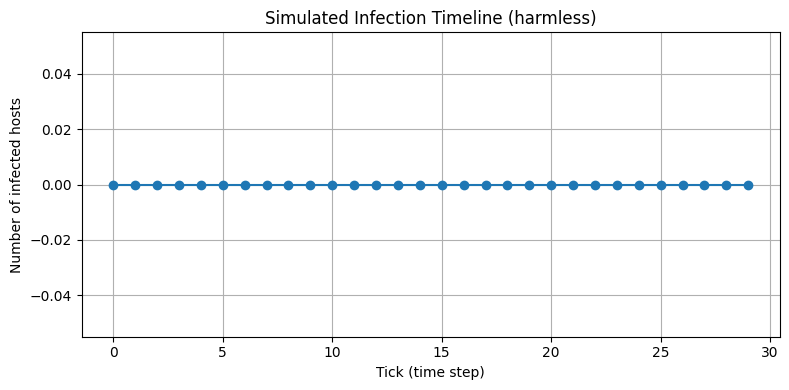


Files created in: ./stuxsim_output
- Log: ./stuxsim_output/stuxsim_log.txt
- Host summary CSV: ./stuxsim_output/stuxsim_summary.csv
- Time series CSV: ./stuxsim_output/stuxsim_timeseries.csv


In [2]:
"""
Harmless Stuxnet-concept simulator — corrected to avoid FileNotFoundError.

Safety summary:
- No networking, no privilege escalation, no exploitation.
- Only creates files in a local output directory (default: ./stuxsim_output).
- Use for classroom demos and learning only.
"""

import os
import random
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG: change only these if desired ---
OUTPUT_DIR = "./stuxsim_output"   # safe local directory (create if missing)
LOGPATH = os.path.join(OUTPUT_DIR, "stuxsim_log.txt")
SUMMARY_CSV = os.path.join(OUTPUT_DIR, "stuxsim_summary.csv")
TIMESERIES_CSV = os.path.join(OUTPUT_DIR, "stuxsim_timeseries.csv")
TICKS = 30
HOST_COUNTS = {"workstation": 6, "hmi": 2, "plc": 8}
USB_EVENT_PROB = 0.12
SCAN_BASE = 0.25
INFECTION_BASE = 0.35
DETECTION_SENSITIVITY = 0.6

# --- Ensure output directory exists BEFORE any file operations ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Now safe to open and write files inside OUTPUT_DIR
def log(msg):
    ts = datetime.utcnow().isoformat() + "Z"
    line = f"{ts} - {msg}"
    print(line)
    with open(LOGPATH, "a", encoding="utf-8") as f:
        f.write(line + "\n")

# --- build hosts list ---
random.seed(42)
hosts = []
host_id = 0
for t, n in HOST_COUNTS.items():
    for i in range(n):
        hosts.append({
            "id": f"{t[:3].upper()}-{host_id:03d}",
            "type": t,
            "infected": False,
            "discovered": False,
            "payload_armed": False,
            "plc_rpm": random.randint(800, 1200) if t=="plc" else None,
            "plc_target_rpm": 1000 if t=="plc" else None,
            "last_seen_tick": -1
        })
        host_id += 1

# Choose a small subset of PLCs to be "target profile" (simulated)
plc_ids = [h["id"] for h in hosts if h["type"]=="plc"]
target_plc_ids = set(random.sample(plc_ids, k=min(2, len(plc_ids))))

# Log header
# (OUTPUT_DIR already exists so log() is safe)
log("=== Harmless Stuxnet-concept Simulator (corrected) starting ===")
log(f"Target PLCs for simulated payload: {', '.join(sorted(target_plc_ids))}")

# --- Simulation helpers (safe, simulated only) ---
def simulate_scan_and_discovery(tick):
    discoveries = []
    for w in [h for h in hosts if h["type"]=="workstation"]:
        if random.random() < SCAN_BASE:
            target = random.choice([h for h in hosts if h["id"] != w["id"]])
            log(f"{w['id']} simulated scan -> observed {target['id']} (type={target['type']})")
            target["last_seen_tick"] = tick
            if random.random() < 0.45:
                target["discovered"] = True
                discoveries.append(target["id"])
                log(f"Simulated discovery: {target['id']} marked as discoverable")
    return discoveries

def simulate_usb_event(tick):
    if random.random() < USB_EVENT_PROB:
        w = random.choice([h for h in hosts if h["type"]=="workstation"])
        log(f"Simulated removable-media event on {w['id']} (untrusted USB inserted)")
        if random.random() < 0.5:
            w["infected"] = True
            log(f"Simulated local infection: {w['id']} set to infected (seed)")
            return True
    return False

def simulate_infection_attempts(tick):
    successes = []
    for w in [h for h in hosts if h["type"]=="workstation" and h["infected"]]:
        targets = [h for h in hosts if h["discovered"] and h["id"] != w["id"] and not h["infected"]]
        for t in targets:
            if random.random() < INFECTION_BASE:
                t["infected"] = True
                t["payload_armed"] = (t["id"] in target_plc_ids)
                successes.append(t["id"])
                log(f"Simulated infection: {t['id']} infected by {w['id']}")
            else:
                log(f"Simulated infection attempt failed: {w['id']} -> {t['id']}")
    return successes

def simulate_payload_tick(tick):
    payload_actions = []
    for p in [h for h in hosts if h["type"]=="plc" and h["infected"] and h["payload_armed"]]:
        delta = random.choice([-120, -80, -40, 0, 40, 80, 120])
        old = p["plc_rpm"]
        p["plc_rpm"] = max(200, min(1800, int(p["plc_rpm"] + delta)))
        payload_actions.append((p["id"], old, p["plc_rpm"]))
        log(f"Simulated payload on {p['id']}: RPM {old} -> {p['plc_rpm']} (simulation only)")
    return payload_actions

def simulate_detection(tick):
    alerts = []
    for p in [h for h in hosts if h["type"]=="plc"]:
        if abs(p["plc_rpm"] - p["plc_target_rpm"]) > 200:
            if random.random() < DETECTION_SENSITIVITY:
                alerts.append((p["id"], p["plc_rpm"]))
                log(f"DETECTION ALERT: {p['id']} RPM anomaly -> {p['plc_rpm']} (simulation)")
    for h in hosts:
        if h["infected"] and random.random() < (DETECTION_SENSITIVITY * 0.25):
            alerts.append((h["id"], "endpoint behavioral alert"))
            log(f"DETECTION ALERT: Endpoint behavioral anomaly on {h['id']} (simulation)")
    return alerts

# --- Run simulation ---
time_series = []
events = []
infected_counts = []

for tick in range(TICKS):
    log(f"--- Tick {tick} ---")
    simulate_usb_event(tick)
    discoveries = simulate_scan_and_discovery(tick)
    successes = simulate_infection_attempts(tick)
    payloads = simulate_payload_tick(tick)
    alerts = simulate_detection(tick)

    infected_counts.append(sum(1 for h in hosts if h["infected"]))
    time_series.append({
        "tick": tick,
        "infected": infected_counts[-1],
        "discoveries": len(discoveries),
        "successful_infections": len(successes),
        "alerts": len(alerts)
    })

    # small chance discovered flags clear
    for h in hosts:
        if h["discovered"] and random.random() < 0.15:
            h["discovered"] = False

    time.sleep(0.05)

log("=== Simulation complete ===")

# --- Save outputs (safe local files) ---
df_hosts = pd.DataFrame(hosts)
df_times = pd.DataFrame(time_series)
summary = {
    "total_hosts": len(hosts),
    "total_infected": int(df_hosts["infected"].sum()),
    "total_plcs_infected": int(df_hosts[(df_hosts["type"]=="plc") & (df_hosts["infected"])].shape[0]),
    "ticks_run": TICKS
}
log(f"Summary: {summary}")

df_hosts.to_csv(SUMMARY_CSV, index=False)
df_times.to_csv(TIMESERIES_CSV, index=False)

# --- Optional: simple plot (requires a display) ---
try:
    plt.figure(figsize=(8,4))
    plt.plot(df_times["tick"], df_times["infected"], marker='o')
    plt.title("Simulated Infection Timeline (harmless)")
    plt.xlabel("Tick (time step)")
    plt.ylabel("Number of infected hosts")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception:
    # plotting may fail in headless environments; that's okay
    log("Plot not displayed (possibly headless environment).")

print("\nFiles created in:", OUTPUT_DIR)
print("- Log:", LOGPATH)
print("- Host summary CSV:", SUMMARY_CSV)
print("- Time series CSV:", TIMESERIES_CSV)
